# End Version

Die Hauptdatei wird mir zu lang, also kommt alles was fertig ist jetzt hier rein.

<p style="font-size:40px; text-align:center">
    Computational Physics / Numerische Verfahren in der Physik; SoSe 2023
</p>
<p style="font-size:15px; text-align:center">
    Lorenz von Smekal, Ralf-Arno Tripolt, Robin Kehr, Johannes Roth, Leon Sieke
</p>
<p style="text-align:center">
    <img src="images/JLU_Giessen-Logo.png" width="400" style="background-color: white; padding: 20px; border-radius: 25px;"/>
</p>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
    Projekt 3: Gezeitenreibung
<b></p>
<p style="font-size:25px; text-align:center">Bearbeitet von Finn Bietz, Florian Adamczyk und Finn Wagner</p>

### Einführung 

In diesem Projekt soll die Gezeitenreibung zwischen Erde und Mond studiert werden. In der folgenden Abbildung ist die Ausprägung zweier Flutberge (der Zenitflutberg ist dem Mond zugewandt, der Nadirflutberg ist dem Mond abgewandt)  skizziert. Diese entstehen durch die Anziehungskraft des Mondes und der Zentrifugalkraft, welche durch die Rotation der Erde um den Schwerpunkt des Erde-Mond Systems erzeugt wird. Da die intrinsische Rotationsperiode der Erde wesentlich kürzer ist als die Umlaufperiode des Mondes, dreht sich die Erde unter den Flutbergen hinweg.

Die dabei entstehende Reibungskraft zwischen den Flutbergen und der mit der Erde rotierenden Materie führt zu einer Verschiebung der Flutberge, so dass sie sich nicht, wie man ohne Reibung erwarten würde, auf der Verbindungslinie des Erd- und Mondmittelpunktes befinden, sondern in Richtung der intrinsischen Erdrotation verschoben sind. Der Zenitflutberg eilt also der Bewegung des Mondes voraus und beschleunigt durch seine Anziehungskraft die Bahnbewegung des Mondes, der sich infolge dessen auf einer größeren Umlaufbahn bewegt. Die intrinsische Rotation der Erde wiederum wird durch die Reibung mit den Flutbergen abgebremst. Diesen Effekt bezeichnet man als Gezeitenreibung. Er ist Gegenstand dieses Projektes. 

<p style="text-align:center">
<img src="images/skizze_gezeitenreibung.png" width="400"/>
</p>

Zur Vereinfachung betrachten wir die Gezeitenreibung nur für das Erde-Mond System  und vernachlässigen den Einfluss der Sonne. In der folgenden Zelle befinden sich verschiedene astronomische Größen des Erde-Mond Systems, welche während des Projektes benötigt werden. 

In [11]:
mErde = 5.9721986*10**24        # kg          : Masse der Erde
mOzean = 0.0014*10**24          # kg          : Masse der Ozeane auf der Erde
RErde = 6.3675*10**6            # kg          : Radius der Erde

mMond = 7.3459*10**22           # kg          : Masse des Mondes 
rMondBahn = 3.836*10**8         # m           : Bahnradius des Mondes, die Umlaufbahn des Mondes um die Erde kann als Kreisbahn genähert werden
TMondBahn = 27.32166140*24*3600 # s           : Heutige Periodendauer der Mondumlaufbahn um die Erde

TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

G = 6.67430*10**(-11)           # m^3/(kg*s^2): Gravitationskonstante 

#### Benötigte Pakete und Einstellungen

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
import scipy
from scipy.integrate._ivp.ivp import OdeResult
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

fastExecution = True # Executing everything all the time takes too long

#### Konventionen für dieses Notebook
Wir haben uns in unserer Gruppe dazu entschieden, die Markdownzellen (den Text) auf Deutsch zu schreiben, im Code jedoch größtenteils Englisch für Kommentare, Erklärungen und auch Variablennamen zu benutzen da: 
* Einerseits ist Python sowieso schon Englisch, da führt es nur zu Verwirrung im Code ständig die Sprache zu wechseln
* Andererseits um die Verständlichkeit auch für andere (nicht deutsche) leser oder bearbeitende Personen zu verbessern. Auch wenn das in speziell diesem Projekt evtl. keine so große Rolle spielt ist es trotzdem "good practice"

$ \def\dv#1{ \frac{\mathrm{d}}{\mathrm{d} #1} } $
$ \def\dd#1{ \ \mathrm{d} #1 } $
$ \def\Vec#1{ \overrightarrow{#1} } $
$ \def\VecT#1#2{ \begin{pmatrix} #1 \\ #2 \end{pmatrix} } $
$ \def\VecE#1{ \hat{e}_{#1} } $

$\providecommand{\e}[1]{\ensuremath{\cdot 10^{#1}}}$ 
$\providecommand{\fehlt}{\textcolor{red}{\textbf{Fehlt!\dots}}}$ 
$\providecommand{\todo}{\textcolor{red}{\textbf{\huge{ToDo}}}}$ 

#### Numerische Integration und lösen von Anfangswertproblemen
Bevor wir mit der eigentlichen Aufgabe beginnen, müssen wir uns noch mit ein paar numerischen Methoden vertraut machen. Dazu werden wir uns in diesem Abschnitt mit der numerischen Integration und dem Lösen von Anfangswertproblemen beschäftigen. Wir implementieren dazu die Euler-Methode und die Runge-Kutta-Methode 4. Ordnung.
Später vergleichen wir die beiden Methoden und vergleichen sie mit der vorgefertigten Funktion `scipy.integrate.solve_ivp`.

##### Euler-Verfahren
Das explizite Euler-Verfahren, auch eulersches Polygonzugverfahren, wurde von Leonhard Euler 1768 veröffentlicht.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0
\end{equation}
Die Differentialgleichungen unseres physikalischen Problems sind gewöhnlich.
Man betrachtet nun nur noch diskrete Zeitpunkte $t_k = t_0 + k \cdot h$ mit $k \in \mathbb{N}_0$,
wobei $h$ die Diskretisierungsschrittweite ist.
$ \newline $
##### Herleitung der Gleichung: $ \newline $
Wir schreiben zunächst die äquivalente Integralgleichung auf:
\begin{equation}
    y(t) = y(t_0) + \int_{t_0}^t f(s, y(s)) \dd{s}
\end{equation}
Setzen wir hier nun eine Zeitpunkt $t_{k+1}$ ein, so erhalten wir:
\begin{equation}
    y(t_{k+1}) = y(t_k) + \int_{t_k}^{t_{k+1}} f(s, y(s)) \dd{s}
\end{equation}
Wir nähern nun das Integral, indem wir die Funktion $f(s, y(s))$ durch eine konstante Funktion $f(t_k, y(t_k))$ (wir wählen den Wert am linken Rand des Bereichs) ersetzen.
\begin{equation}
    y(t_{k+1}) = y(t_k) + (t_{k+1} - t_k) \cdot f(t_k, y(t_k))
\end{equation}
Die Differenz $t_{k+1} - t_k$ ist die Diskretisierungsschrittweite $h$.
\begin{equation}
    y(t_{k+1}) = y(t_k) + h \cdot f(t_k, y(t_k)) \quad \mathrm{mit} \quad k \in \mathbb{N}_0
\end{equation}
$ \newline $
$\textbf{Quelle:}$ [Wikipedia: Explizites Euler-Verfahren](https://de.wikipedia.org/wiki/Explizites_Euler-Verfahren) und Skript Kapitel 7

In [13]:
def explicit_euler(fun, t_span, y_0, steps, args=()):
    '''Implementation of the explicit Euler method'''
    # Calculate h, the time step, from the number of steps
    h = (t_span[1]-t_span[0])/steps
    # Create an array of the time steps
    t = np.linspace(t_span[0], t_span[1], steps+1, dtype=np.float64)
    # Create an array for the solution
    y = np.zeros((steps+1, len(y_0)), dtype=np.float64)
    # Set the initial conditions
    y[0] = y_0
    # Iterate over the time steps
    for i in range(steps):
        # Calculate the next step using the explicit Euler method
        y[i+1] = y[i] + h*fun(t[i], y[i], *args)
    return OdeResult(t=t, y=y.T)

Das explizite Runge-Kutta 4.Ordnung oder auch das "Klassisches Runge-Kutta-Verfahren" (RK4) ist nach Carl Runge und Martin Kutta benannt.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0, \quad y: \mathbb{R} \rightarrow \mathbb{R}^n
\end{equation}
Es werden vier Zwischenwerte verwendet:
\begin{align}
    k_1 &= f(t_k, y_k) \\
    k_2 &= f(t_k + \frac{h}{2}, y_k + \frac{h}{2} k_1) \\
    k_3 &= f(t_k + \frac{h}{2}, y_k + \frac{h}{2} k_2) \\
    k_4 &= f(t_k + h, y_k + h k_3)
\end{align}
Die Näherung für $y_{k+1}$ lautet dann:
\begin{equation}
    y_{k+1} = y_k + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4)
\end{equation}


$ \newline $
$\textbf{Quelle:}$ [Wikipedia: Klassisches Runge-Kutta-Verfahren](https://de.wikipedia.org/wiki/Klassisches_Runge-Kutta-Verfahren) und Skript Vorlesung 7: Kapitel 3.1.2: Runge-Kutta Algorithmus

In [14]:
def classic_runge_kutta(fun, t_span, y_0, steps, args=()):
    '''Implementation of the classic Runge-Kutta method'''
    # Calculate h, the time step, from the number of steps
    h = (t_span[1]-t_span[0])/steps
    # Create an array of the time steps
    t = np.linspace(t_span[0], t_span[1], steps+1, dtype=np.float64)
    # Create an array for the solution
    y = np.zeros((steps+1, len(y_0)), dtype=np.float64)
    # Set the initial conditions
    y[0] = y_0
    # Iterate over the time steps
    for i in range(steps):
        # Calculate the next step using the Runge-Kutta method
        k1 = h*fun(t[i], y[i], *args)
        k2 = h*fun(t[i]+h/2, y[i]+k1/2, *args)
        k3 = h*fun(t[i]+h/2, y[i]+k2/2, *args)
        k4 = h*fun(t[i]+h, y[i]+k3, *args)
        y[i+1] = y[i] + 1/6*(k1+2*k2+2*k3+k4)
    return OdeResult(t=t, y=y.T)

In [15]:
def solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options):
    if method == 'euler':
        return explicit_euler(fun, t_span, y0, options['steps'], args)
    elif method == 'RK4':
        return classic_runge_kutta(fun, t_span, y0, options['steps'], args)
    else:
        options.pop('steps', None)
        return scipy.integrate.solve_ivp(fun, t_span, y0, method, t_eval, dense_output, events, vectorized, args, **options)

### Leitfragen

#### Zweikörperproblem

Zur Vereinfachung lassen wir zunächst die intrinsische Rotation der Erde, sowie die Flutberge weg.
Wir betrachten die beiden Körper als Punktmassen, die sich nur in der $x$-$y$-Ebene bewegen können.
Diese Vereinfachungen entsprechen dem klassiche Zweikörperproblem, dass von Johannes Kepler aufgeschrieben und zuerst analytisch von Isaac Newton gelöst wurde.
Sie sind ein System von gekoppelten Differentialgleichungen, die die Bewegung der beiden Körper beschreiben.
$\newline$
Wir betrachten zwei Körper und stellen dementsprechend zwei Differentialgleichungen auf:
\begin{align*}
    m_1 \Vec{\ddot{z_1}} &= \Vec{F_{1,2}} \\
    m_2 \Vec{\ddot{z_2}} &= \Vec{F_{2,1}}
\end{align*}
$\vec{F_{2,1}}$ steht für die Kraft, die die beiden Körper anzieht.
Hierbei handelt es sich um die Schwerkraft:
\begin{gather*}
    \Vec F_1 = G \frac{m_1 \cdot m_2}{r^2} \Vec e_{12} \quad \mathrm{mit} \ r := \left| \Vec{z_2} - \Vec{z_1} \right|
\end{gather*}
Zusätzlich gilt nach dem 3.ten Newtonschen Gesetz
\begin{equation*}
    \Vec{F_{1,2}} = -\Vec{F_{2,1}}
\end{equation*}
Wir setzen das Gravitationsgesetz nun in unsere DGLs ein und erhalten:
\begin{align*}
    \ddot{z_1} = \frac{G \cdot m_2}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_2} - \Vec{z_1} \right) \\
    \ddot{z_2} = \frac{G \cdot m_1}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_1} - \Vec{z_2} \right) \\
\end{align*}
Wir erhalten also vier Gleichungen:
\begin{align*}
    \ddot{x_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
    \ddot{y_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
    \ddot{x_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_1 - x_2 \right) \\
    \ddot{y_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
\end{align*}

Die Methode `solve_ivp()` kann keine Differentialgleichungen $n$-ter Ordnung lösen.
Wir formen deshalb unser Problem in ein DGL-System erster Ordnung um.
$\newline$
Dazu führen wir die neuen Variable $v$ und $a$ ein:
\begin{gather*}
    \dv{t} x_1(t) = v_1(t) \\
    \dv{t} v_1(t) = \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
\end{gather*}
Dieses Verfahren wenden wir äquivalent für die anderen drei Gleichungen an.
$\newline$
Wir schreiben diese Differentialgleichungen nun in eine Funktion, die wir dann an `solve_ivp()` übergeben können.
Die Massen der Körper könen wir als Parameter übergeben.
$\newline$
Außerdem wählen wir die Anfangsbedingungen analog zu den real herschenden Bedingungen so, dass der Schwerpunkt des Zweiteilchensystems im Ursprung ruht. $\newline$
Für einfacheres Aufrufen definieren wir noch eine Funktion zum Erstellen der Anfangsbedingungen, sowie eine Funktion die damit die Differentialgleichungen löst.

In [16]:
def baryzentrum(m1, m2, r):
    '''Calculate the barycenter of two bodies (The point around which both bodies orbit)
    Returns the distance of the barycenter from the body with mass m1 '''
    return r*m2/(m1+m2)

def iv_stable_orbit_2body():
    '''Initial conditions for the Earth-Moon system in a stable orbit'''
    mass = [mErde, mMond]
    
    # We want the center of mass to be at the origin
    abstand_baryzentrum_erde = baryzentrum(mErde, mMond, rMondBahn)
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn-abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]
    return [x0_Erde, x0_Mond, v0_Erde, v0_Mond, mass]

def eq_motion_2body(t, state, mass):
    '''This function calculates the derivatives of the state vector for the two body problem to be passed to solve_ivp. \\
    state: state vector is given by [x_1, y_1, x_2, y_2, vx_1, vy_1, vx_2, vy_2] where the 1 and 2 denote the first and second body.
    mass: list of the masses of the two bodys. e.g. [m1, m2]'''
    x_1, y_1, x_2, y_2, vx_1, vy_1, vx_2, vy_2 = state
    dist_em = ((x_2 - x_1)**2 + (y_2 - y_1)**2 )**0.5 # Distance between the two bodys
    # Calculate the derivatives of the state vector
    dx1_dt = vx_1
    dy1_dt = vy_1
    dx2_dt = vx_2
    dy2_dt = vy_2
    dv_x1_dt = G * mass[1] / (dist_em**3) * (x_2 - x_1)
    dv_y1_dt = G * mass[1] / (dist_em**3) * (y_2 - y_1)
    dv_x2_dt = G * mass[0] / (dist_em**3) * (x_1 - x_2)
    dv_y2_dt = G * mass[0] / (dist_em**3) * (y_1 - y_2)

    return np.array([dx1_dt, dy1_dt, dx2_dt, dy2_dt, dv_x1_dt, dv_y1_dt, dv_x2_dt, dv_y2_dt])

def two_body_problem(pos_body_1: list, pos_body_2: list, vel_body_1: list, vel_body_2: list, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    ''' This Function solves the two body problem numerically using solve_ivp and the function eq_motion_2body.
    The arguments are list holding x and y-components of the position and velocity of the two bodys.
    mass: contains the masses of the bodys'''

    solution = solve_ivp(eq_motion_2body, [t_start, t_max], [*pos_body_1, *pos_body_2, *vel_body_1, *vel_body_2], args=(mass,), atol=1e-4*rMondBahn, max_step=TMondBahn/1000, steps=steps, method=method)
    x1, y1, x2, y2, v_x1, v_y1, v_x2, v_y2 = solution.y
    return [solution.t, x1, y1, x2, y2]

##### Graphische Darstellung
Im folgenden erstellen wir parametrische zeitliche Verläufe der Positionen der beiden Körper, sowie Phasenraumplots.
Zusätzlich einen 3d Plot der Bahnen der beiden Körper, sowie eine Animation. 

In [17]:
# Calculate the solution of the two body problem
t, x_1, y_1, x_2, y_2 = two_body_problem(*iv_stable_orbit_2body(), 3*TMondBahn)

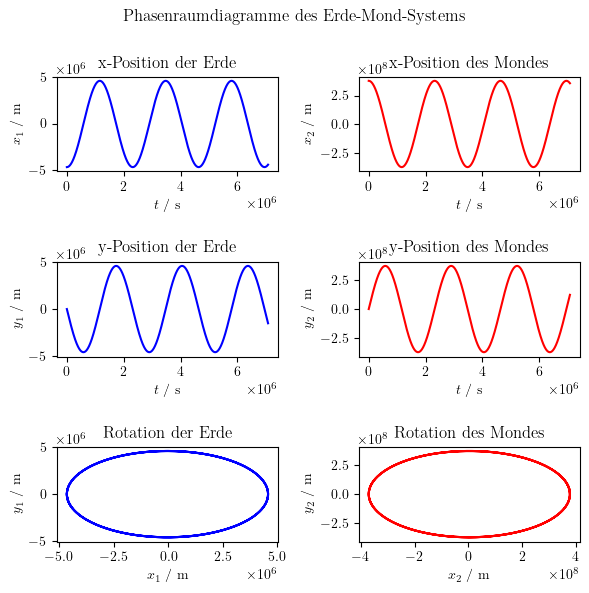

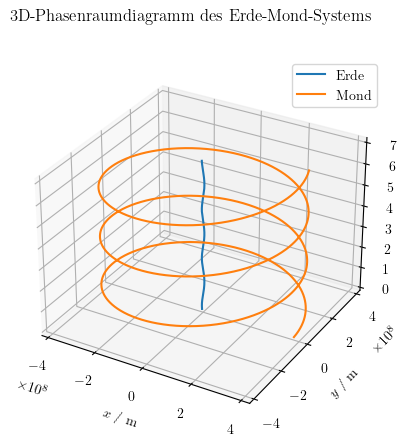

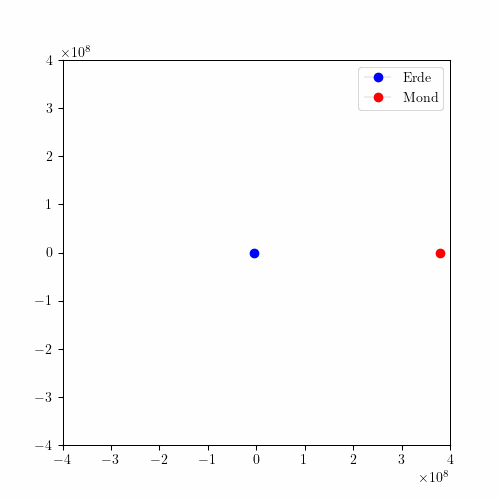

In [18]:
%matplotlib inline
# Plot the solution of the two body problem as a phase space diagram
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 6)) # Create a figure and a set of subplots
fig.suptitle("Phasenraumdiagramme des Erde-Mond-Systems")

def init_phase_space(ax, a, b, title, xlabel, ylabel, color):
    ax.plot(a, b, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

init_phase_space(axes[0,0], t, x_1, "x-Position der Erde", "$t$ / s", "$x_1$ / m", "blue")
init_phase_space(axes[0,1], t, x_2, "x-Position des Mondes", "$t$ / s", "$x_2$ / m", "red")
init_phase_space(axes[1,0], t, y_1, "y-Position der Erde", "$t$ / s", "$y_1$ / m", "blue")
init_phase_space(axes[1,1], t, y_2, "y-Position des Mondes", "$t$ / s", "$y_2$ / m", "red")
init_phase_space(axes[2,0], x_1, y_1, "Rotation der Erde", "$x_1$ / m", "$y_1$ / m", "blue")
init_phase_space(axes[2,1], x_2, y_2, "Rotation des Mondes", "$x_2$ / m", "$y_2$ / m", "red")
plt.tight_layout() # Adjust the spacing between subplots
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()
fig.suptitle("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_1, y_1, t, label="Erde")
ax.plot(x_2, y_2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Animation of the two body problem
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label="Erde")
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label="Mond")
    ax.legend()

    def animate(i):
        earth_line.set_data([x_1[i]], [y_1[i]])
        moon_line.set_data([x_2[i]], [y_2[i]])
        return earth_line, moon_line

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond.gif', writer='pillow')
    plt.close()

display(Image(data=open('Erde_Mond.gif','rb').read(), format='png'))

#### Überprüfung

Nachem wir uns unsere Lösungen nun grafisch angeschaut haben, wollen wir diese noch auf ihre Korrektheit überprüfen.
Wir betrachten dazu das Baryzentrum. Dabei untersuchen wir was für einen Fehler die numerische Lösung bringt, indem wir verschiedene Verfahren vergleichen.

##### Baryzentrum

Zur Überprüfung unserer Ergebnisse und Anfangsbedingungen betrachten wir die Bewegung des Schwerpunktes. $\newline$
Der Schwerpunkt sollte sich in einem abgeschlossenen System, mit den von uns gewählten Anfangsbedingungen, nicht bewegen.
Gegen die Zeit aufgetragen, sollten seine x-, und y-Komponente also eine Konstante bei Null (wegen der Anfangsbedingungen, Schwerpunkt im Ursprung) sein.
Wie im Plot jedoch zu sehen ist, ist dies bei unseren Berechnungen nicht der Fall.
Die hier bestimmten Werte liegen aber im Bereich von $10^{-5}$ Metern, sind also um mehrere Größenordnungen kleiner als unsere betrachteten Abstände zwischen Erde und Mond.
Diese Fehler entstehen hier durch die numerische Berechnung des Problems.
Sie entstehen hier entweder durch das numerische Lösen der DGL oder durch die
Ungenauigkeit des float-Datentypen und der angegebenen Anfangswerte.

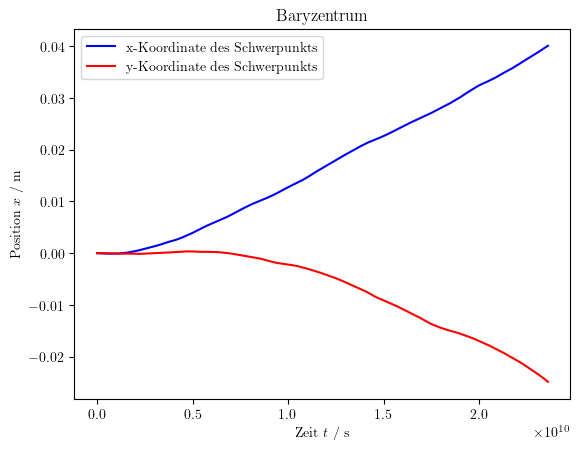

In [22]:
solution = two_body_problem(*iv_stable_orbit_2body(), (1 if fastExecution else 20)*TMondBahn)
t, x_1, y_1, x_2, y_2 = solution

def center_of_mass(m1, m2, x_1, y_1, x_2, y_2):
    '''Calculates the location of the center of mass of two bodies with masses m1 and m2 at positions (x1, y_1) and (x2, y_2)'''
    x_cm = (m1*x_1 + m2*x_2) / (m1 + m2)
    y_cm = (m1*y_1 + m2*y_2) / (m1 + m2)
    return x_cm, y_cm

%matplotlib inline
# Plot the change of the center of mass over time
fig, ax = plt.subplots()
fig.set_label("Bewegung des Baryzentrum des Erde-Mond-Systems")
ax.plot(t, center_of_mass(mErde, mMond, x_1, y_1, x_2, y_2)[0], color='blue', label='x-Koordinate des Schwerpunkts')
ax.plot(t, center_of_mass(mErde, mMond, x_1, y_1, x_2, y_2)[1], color='red', label='y-Koordinate des Schwerpunkts')
ax.set_xlabel('Zeit $t$ / s')
ax.set_ylabel('Position $x$ / m')
ax.set_title('Baryzentrum')
ax.legend()
plt.show()
plt.close()

##### Vergleich von explizitem Euler-Verfahren, Runge-Kutta-Verfahren 4. Ordnung und Runge-Kutta-Verfahren 45 (Standard in `solve_ivp()`)

Zwischen der Lösung mit dem expliziten Euler-Verfahren und der Lösung mit dem Runge-Kutta-Verfahren 4. Ordnung ist ein deutlicher Unterschied zu erkennen.
Es ist deutlich zu sehen, dass der Orbit des Mondes mit jedem Umlauf größer wird. Hier wird also eindeutig ein größerer numerischer Fehler gemacht.
Beim RK4 und RK45 ist derartiges nicht zu erkennen. Sie sind voneinander nicht zu unterscheiden.
Dies ist auch zu erwarten, da RK45 eine Weiterentwicklung von RK4 ist und nur bei sehr großen Schrittweiten Unterschiede zu erkennen sind.
Das Euler-Verfahren ist also in der Tat schlechter als das RK4-Verfahren, dafür aber auch deutlich weniger aufwendig. Diese kleine Genauigkeitseinbuße ist aber zu verschmerzen.

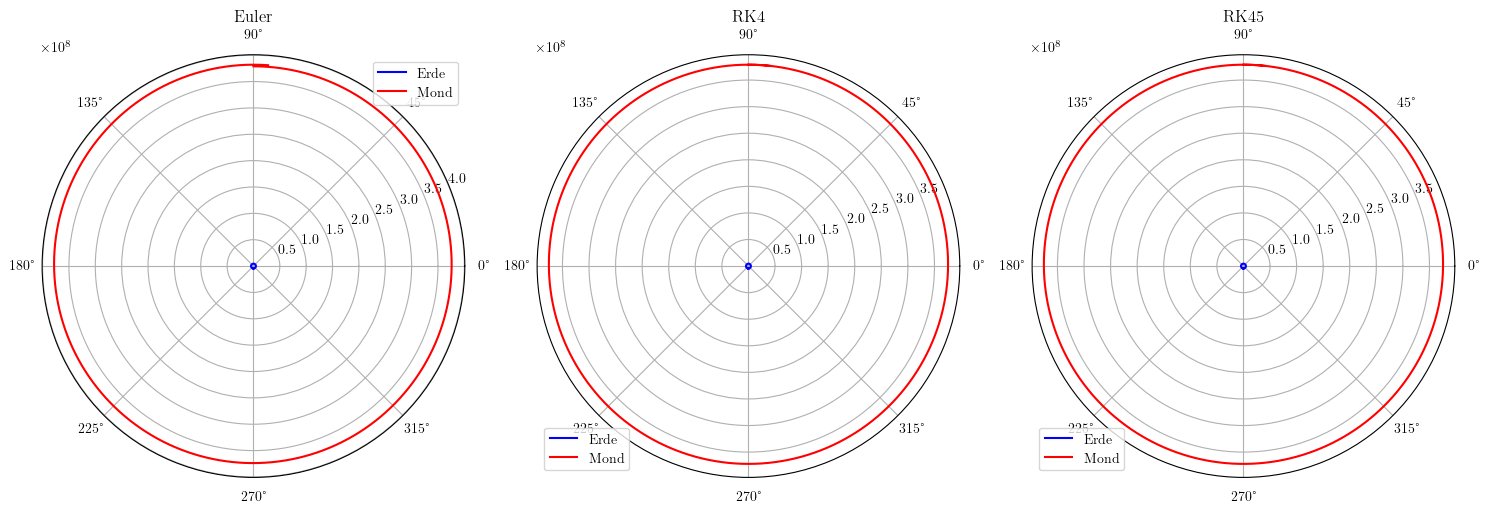

In [ ]:
%matplotlib inline
revolutions = (1 if fastExecution else 6)
solution_euler = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="euler")
solution_rk4 = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="RK4")
solution_rk45 = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="RK45")

# To plot the solution in polar coordinates we need to convert the cartesian coordinates to polar coordinates
r = lambda x, y: np.sqrt(x**2 + y**2)
theta = lambda x, y: np.arctan2(x, y)

# Create a figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows= 1, ncols=3, figsize=(15, 15), subplot_kw={'projection': 'polar'})

def init_ploar(ax, t, x_1, y_1, x_2, y_2, title, color_1, color_2, label_1, label_2):
    ax.plot(theta(x_1, y_1), r(x_1, y_1), color=color_1, label=label_1)
    ax.plot(theta(x_2, y_2), r(x_2, y_2), color=color_2, label=label_2)
    ax.set_title(title)
    ax.legend()

init_ploar(ax1, *solution_euler, "Euler", "blue", "red", "Erde", "Mond")
init_ploar(ax2, *solution_rk4, "RK4", "blue", "red", "Erde", "Mond")
init_ploar(ax3, *solution_rk45, "RK45", "blue", "red", "Erde", "Mond")
plt.tight_layout()
plt.show()
plt.close()